# Final models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Last time on feature engineering...

In [2]:
df_original = pd.read_csv("census_income_dataset.csv")
df = df_original.replace('?',np.nan).replace(-100000, np.nan)

In [3]:
# dealing with columns
df = df.drop(['fnlwgt', 'education', 'relationship'], axis= 1)

# maritial status
df['married'] = np.where(df.marital_status.isin(['Married-civ-spouse', 'Married-AF-spouse']), 'married', 'not_married')
df = df.drop(['marital_status'], axis = 1)

# country
x = df.groupby(['income_level', 'native_country'])['age'].agg(['count'])
shares = x / x.groupby(level=1).sum()
shares = shares.reset_index()
shares = shares[shares.income_level == '<=50K']

share_USA = shares[shares.native_country == 'United-States']['count'].values[0]

df['country_less_USA'] = np.where(df['native_country'].isin(shares[shares['count'] < share_USA]['native_country']), 'country_less_USA', 'NOT_country_less_USA')
df['country_more_USA'] = np.where(df['native_country'].isin(shares[shares['count'] > share_USA]['native_country']), 'country_more_USA', 'NOT_more_less_USA')

df = df.drop(['native_country'], axis = 1)

# df['country_USA'] = np.where((df['country_less_USA'] + df['country_more_USA']) == 0, 'country_USA', 'NOT_country_USA')

In [4]:
# split into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='income_level'), df['income_level'], test_size=0.2, random_state=42)

In [5]:
# we don't have to scale numerical values as we will be using only tree-based models

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# categorical = ['workclass', 'occupation', 'race', 'sex', 'married','country_USA' ,'country_less_USA', 'country_more_USA']
categorical = ['workclass', 'occupation', 'race', 'sex', 'married' ,'country_less_USA', 'country_more_USA']
# numerical = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

# numeric_transformer = StandardScaler()

# placeholder for encoding categorical variables
categorical_transformer = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                    ('onehot_encoding', OneHotEncoder(drop='first')) ])

preprocessor = ColumnTransformer(
    transformers=[
        # ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)],
        remainder='passthrough')

In [6]:
# source: https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html

def get_feature_names(column_transformer):
    import warnings
    import sklearn
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names


## Dealing with unbalanced classes - oversampling minority class

In [7]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
less_50 = X[X.income_level=='<=50K']
more_50 = X[X.income_level=='>50K']

# upsample minority
more_50_upsampled = resample(more_50,
                            replace=True, # sample with replacement
                            n_samples=len(less_50), # match number in majority class
                            random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([less_50, more_50_upsampled])

# check new class counts
upsampled.income_level.value_counts()

<=50K    29741
>50K     29741
Name: income_level, dtype: int64

In [8]:
X_train_up = upsampled.drop(['income_level'], axis = 1)
y_train_up = upsampled.income_level

## Hyperparameter tuning

Last time we created many models. The best results were achived by tree-based models like Decision Tree, Random Forest and XGBoost, so we decided to use only them as candidates for our final model.

### Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

dt_grid = {
    'model__criterion' : ['gini', 'entropy'],
    'model__max_depth' : [2, 4, 6, 8, 10, 12]
}

dt = DecisionTreeClassifier(random_state=42)
pipeline_dt = Pipeline([('preprocessing', preprocessor), 
                        ('model', dt)])
gs_dt = GridSearchCV(pipeline_dt, dt_grid, n_jobs = -1, cv = 3, scoring='roc_auc')

gs_dt.fit(X_train_up, y_train_up)

best_model_dt = gs_dt.best_estimator_

print(classification_report(y_test, best_model_dt.predict(X_test)))

              precision    recall  f1-score   support

       <=50K       0.95      0.78      0.85      7414
        >50K       0.55      0.86      0.67      2355

    accuracy                           0.80      9769
   macro avg       0.75      0.82      0.76      9769
weighted avg       0.85      0.80      0.81      9769



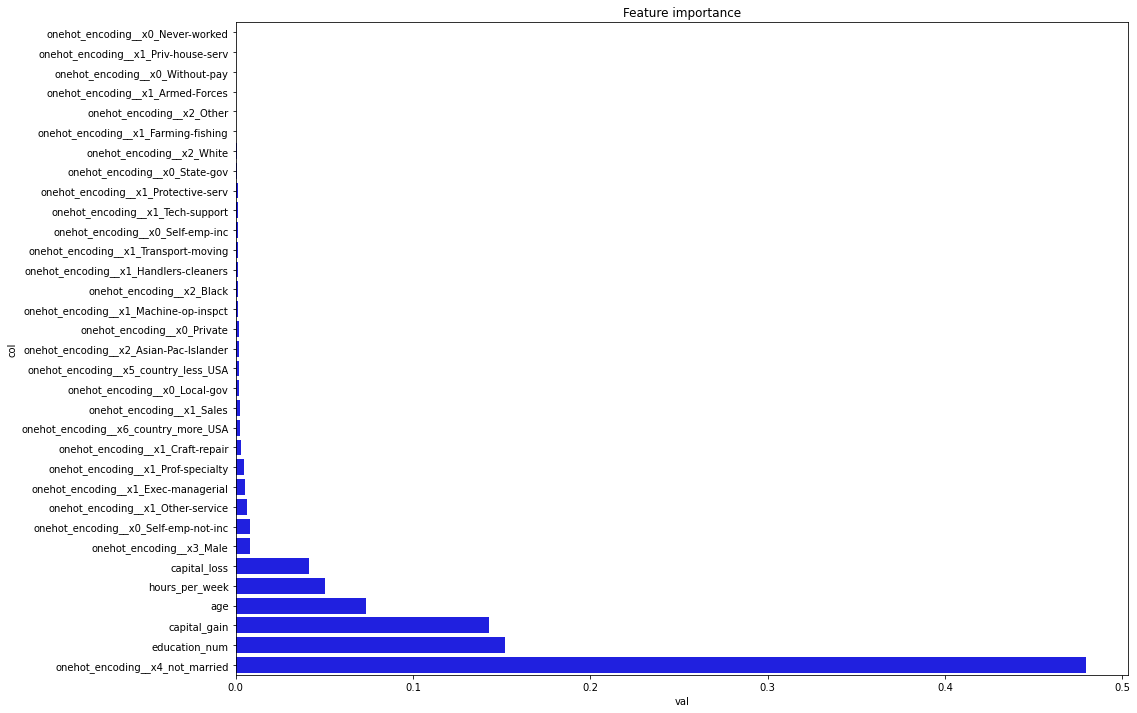

In [10]:
tmp = pd.DataFrame({'val' : best_model_dt.steps[1][1].feature_importances_, 'col' : get_feature_names(best_model_dt.steps[0][1])})
tmp = tmp.sort_values(by = 'val')

plt.figure(figsize=(16, 12))
plt.title("Feature importance")
sns.barplot(y="col", x="val", data=tmp, color = 'blue');

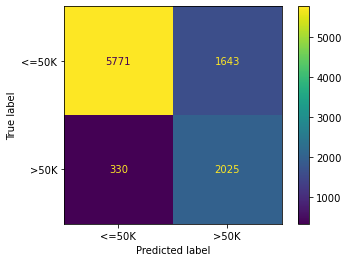

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, best_model_dt.predict(X_test), labels = y_train_up.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = y_train_up.unique())
disp.plot(values_format = 'd')
plt.show()

In [12]:
from sklearn.metrics import roc_auc_score
print(f"ROC_AUC score : {roc_auc_score(np.where(y_test == '>50K', 1, 0), best_model_dt.predict_proba(X_test)[:, 1])}")

ROC_AUC score : 0.891490191563903


In [34]:
print(f"ROC_AUC score on train set : {roc_auc_score(np.where(y_train == '>50K', 1, 0), best_model_dt.predict_proba(X_train)[:, 1])}")

ROC_AUC score on train set : 0.932520041254002


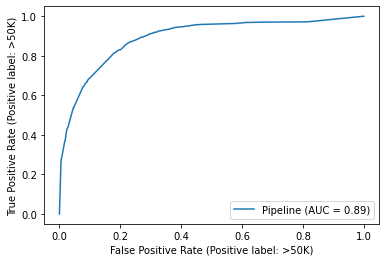

In [25]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(best_model_dt, X_test, y_test)
plt.show()                                   

### Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf_grid = {
    'model__criterion' : ['gini', 'entropy'],
    'model__max_depth' : [2, 4, 6, 8, 10],
    'model__n_estimators' : [5, 10, 15, 20, 50, 70]
}

rf = RandomForestClassifier(random_state=42)
pipeline_rf = Pipeline([('preprocessing', preprocessor), 
                        ('model', rf)])
gs_rf = GridSearchCV(pipeline_rf, rf_grid, n_jobs = -1, cv = 3, scoring='roc_auc')

gs_rf.fit(X_train_up, y_train_up)

best_model_rf = gs_rf.best_estimator_

print(classification_report(y_test, best_model_rf.predict(X_test)))

              precision    recall  f1-score   support

       <=50K       0.95      0.78      0.86      7414
        >50K       0.56      0.87      0.68      2355

    accuracy                           0.80      9769
   macro avg       0.75      0.83      0.77      9769
weighted avg       0.86      0.80      0.81      9769



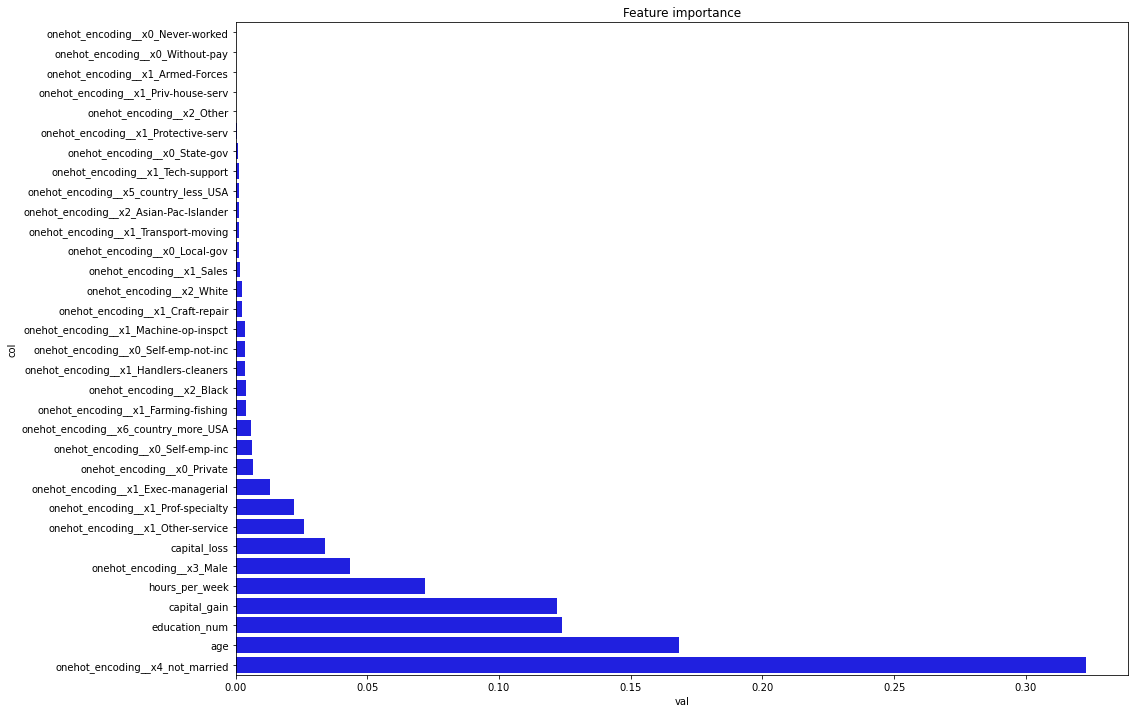

In [14]:
tmp = pd.DataFrame({'val' : best_model_rf.steps[1][1].feature_importances_, 'col' : get_feature_names(best_model_dt.steps[0][1])})
tmp = tmp.sort_values(by = 'val')

plt.figure(figsize=(16, 12))
plt.title("Feature importance")
sns.barplot(y="col", x="val", data=tmp, color = 'blue');

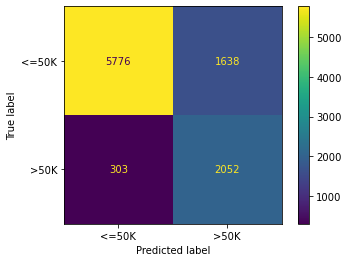

In [15]:
cm = confusion_matrix(y_test, best_model_rf.predict(X_test), labels = y_train_up.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = y_train_up.unique())
disp.plot(values_format = 'd')
plt.show()

In [16]:
print(f"ROC_AUC score : {roc_auc_score(np.where(y_test == '>50K', 1, 0), best_model_rf.predict_proba(X_test)[:, 1])}")

ROC_AUC score : 0.9122083256729536


In [33]:
print(f"ROC_AUC score on train set : {roc_auc_score(np.where(y_train == '>50K', 1, 0), best_model_rf.predict_proba(X_train)[:, 1])}")

ROC_AUC score on train set : 0.927266996007091


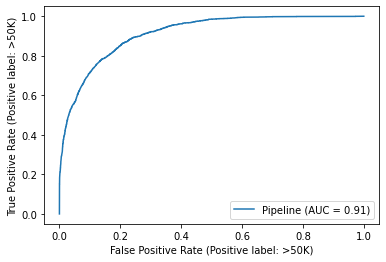

In [26]:
plot_roc_curve(best_model_rf, X_test, y_test)
plt.show()  

### XGBoost

In [18]:
import xgboost as xgb

xgb_grid = {
    'model__objective': ['binary:logistic'],
    'model__n_estimators' : [5, 10, 15, 20, 50, 70],
    'model__max_depth' : [2, 4, 6, 8, 10]
    }

xgb = xgb.XGBClassifier(random_state=42)

pipeline_xgb = Pipeline([('preprocessing', preprocessor), 
                        ('model', xgb)])
gs_xgb = GridSearchCV(pipeline_xgb, xgb_grid, n_jobs = -1, cv = 3, scoring='roc_auc')

gs_xgb.fit(X_train_up, y_train_up)
best_model_xgb = gs_xgb.best_estimator_

print(classification_report(y_test, best_model_xgb.predict(X_test)))

[20:51:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

       <=50K       0.93      0.84      0.88      7414
        >50K       0.61      0.82      0.70      2355

    accuracy                           0.83      9769
   macro avg       0.77      0.83      0.79      9769
weighted avg       0.86      0.83      0.84      9769



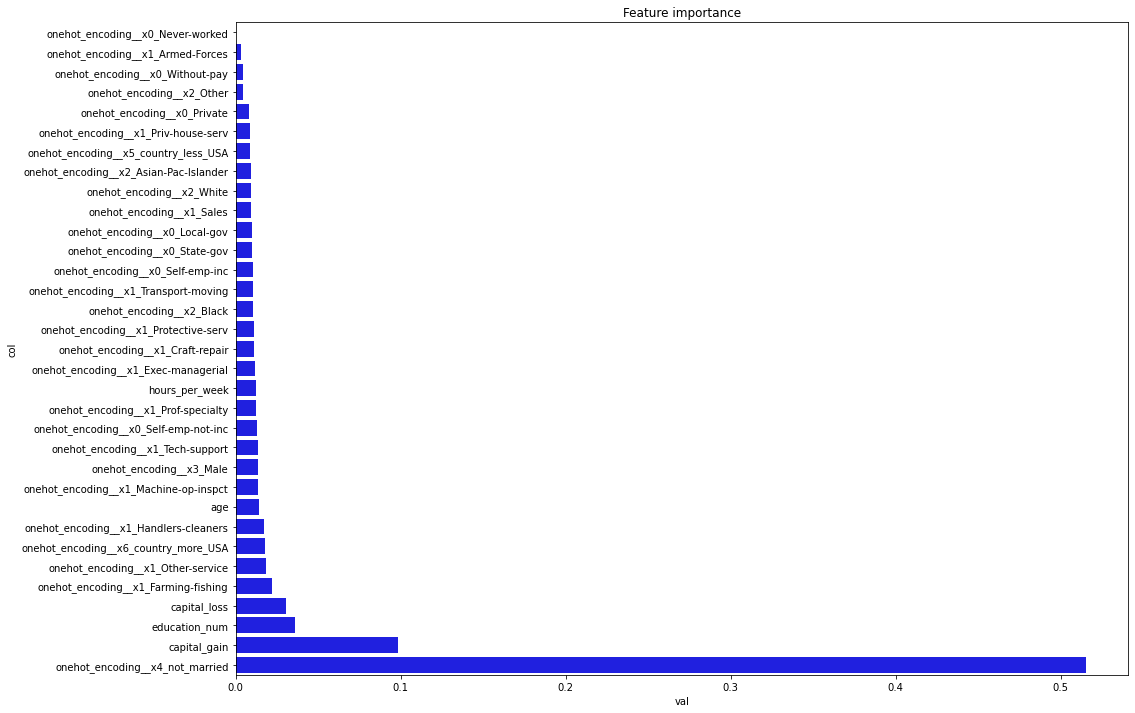

In [19]:
tmp = pd.DataFrame({'val' : best_model_xgb.steps[1][1].feature_importances_, 'col' : get_feature_names(best_model_dt.steps[0][1])})
tmp = tmp.sort_values(by = 'val')

plt.figure(figsize=(16, 12))
plt.title("Feature importance")
sns.barplot(y="col", x="val", data=tmp, color = 'blue');

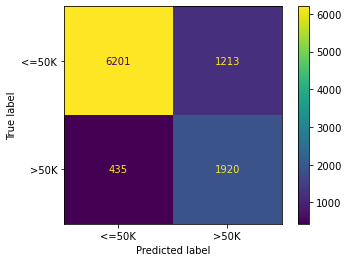

In [20]:
cm = confusion_matrix(y_test, best_model_xgb.predict(X_test), labels = y_train_up.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = y_train_up.unique())
disp.plot(values_format = 'd')
plt.show()

In [28]:
from sklearn.metrics import roc_auc_score
print(f"ROC_AUC score : {roc_auc_score(np.where(y_test == '>50K', 1, 0), best_model_xgb.predict_proba(X_test)[:, 1])}")

ROC_AUC score : 0.9180081065431385


In [35]:
print(f"ROC_AUC score on train test : {roc_auc_score(np.where(y_train == '>50K', 1, 0), best_model_xgb.predict_proba(X_train)[:, 1])}")

ROC_AUC score on train test : 0.9659925936092385


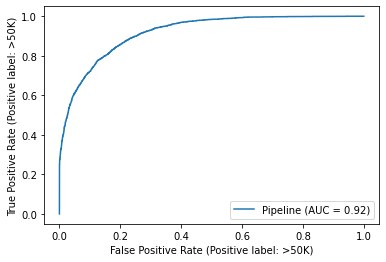

In [27]:
plot_roc_curve(best_model_xgb, X_test, y_test)
plt.show()  

### Saving final models to file

In [22]:
# in order not to run all tunnings one more time...
import pickle

results = {
    'decision_tree' : {
        'gs_object' : gs_dt,
        'best_model' : best_model_dt
    },
    'random_forest' : {
        'gs_object' : gs_rf,
        'best_model' : best_model_rf
    },
    'xgboost' : {
        'gs_object' : gs_xgb,
        'best_model' : best_model_xgb
    }
}

with open('models_over.npy', 'wb') as f:
    pickle.dump(results, f)

## Parametry najlepszego modelu

In [4]:
import pickle
with open('models_over.npy', "rb") as f:
    results_loaded = pickle.load(f)

In [5]:
import xgboost as xgb
results_loaded.get('xgboost').get('gs_object').best_params_

{'model__max_depth': 10,
 'model__n_estimators': 70,
 'model__objective': 'binary:logistic'}